# Text Classification

In our previous post, we covered some of the [basics of sentiment analysis](/sentiment-analysis-reddit-headlines-pythons-nltk/), where we gathered and categorize political headlines. Now, we can use that data to train a binary classifier to predict if a headline is positive or negative. 

## Brief Intro Using Classification and Some Problems We Face

Classification is the process of identifying the category of a new, unseen observation based of a training set of data, which has categories that are known. 

In our case, our headlines are the observations and the positive/negative sentiment are the categories. This is a **binary classification** problem -- we're trying to predict if a headline is either positive or negative.

### First Problem: Imbalanced Dataset

One of the most common problems, in machine learning, is working with an imbalanced dataset. As we'll see below, we have a *slightly* imbalanced dataset, where there's more negatives than positives. 

Compared to some problems, like fraud detection, our dataset isn't super imbalanced. Sometimes you'll have datasets where the positive class is only 1% of the training data, the rest being negatives.

We want to be careful with interpreting results from imbalanced data. When producing scores with our classifier, you may experience accuracy up to 90%, which is commonly known as the [Accuracy Paradox](https://en.wikipedia.org/wiki/Accuracy_paradox). 

The reason why we might have 90% accuracy is due to our model examining the data and deciding to always predict *negative*, resulting in high accuracy. 

There's a number of ways to counter this problem, such as::

* **Collect more data:** could help balance the dataset by adding more minor class examples.
* **Change you metric:** use either the Confusion Matrix, Precision, Recall or F1 score (combination of precision and recall).
* **Oversample the data:** randomly sample the attributes from examples in the minority class to create more 'fake' data.
* **Penalized model:**  Implements an additional cost on the model for making classification mistakes on the minority class during training. These penalties bias the model towards the minority class.

In our dataset, we have less positive examples than negative examples, and we will explore both different metrics and utilizing an oversampling technique, called SMOTE.

Let's establish a few basic imports:

In [229]:
import math
import random
from collections import defaultdict
from pprint import pprint

# Prevent future/deprecation warnings from showing in output
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set global styles for plots
sns.set_style(style='white')
sns.set_context(context='notebook', font_scale=1.3, rc={'figure.figsize': (16,9)})

These are basic imports used across the entire notebook, and are usually imported in every data science project. The more specific imports from sklearn and other libraries will be brought up when we use them.

## Loading the Dataset

First let's load the dataset that we created in the last article:

In [230]:
df = pd.read_csv('reddit_headlines_labels.csv', encoding='utf-8')
df.head()

,headline,label
0,Gillespie Victory In Virginia Would Vindicate ...,0
1,"Screw Ron Paul and all of his ""if he can't aff...",-1
2,"Corker: Trump, 'perfectly fine,' with scrappin...",1
3,Concerning Recent Changes in Allowed Domains,0
4,"Trump confidantes Bossie, Lewandowski urge aga...",-1


Now that we have the dataset in a dataframe, let's remove the neutral (0) headlines labels so we can focus on only classifying positive or negative:

In [231]:
df = df[df.label != 0]
df.label.value_counts()

-1    758
 1    496
Name: label, dtype: int64

Our dataframe now only contains positive and negative examples, and we've confirmed again that we have more negatives than positives.

Let's move into featurization of the headlines.

## Transform Headlines into Features

In order to train our classifier, we need to transform our headlines of words into numbers, since algorithms only know how to work with numbers.

To do this transformation, we're going to use `CountVectorizer` from sklearn. This is a very straightforward class for converting words into features.

Unlike in the last tutorial where we manually tokenized and lowercased the text, `CountVectorizer` will handle this step for us. All we need to do is pass it the headlines.

Let's work with a tiny example to show how vectorizing words into numbers works:

In [232]:
from sklearn.feature_extraction.text import CountVectorizer

s1 = "Senate panel moving ahead with Mueller bill despite McConnell opposition"
s2 = "Bill protecting Robert Mueller to get vote despite McConnell opposition"

vect = CountVectorizer(binary=True)
X = vect.fit_transform([s1, s2])

X.toarray()

array([[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]], dtype=int64)

What we've done here is take two headlines about a similar topic and vectorized them.

`vect` is set up with default params to tokenize and lowercase words. On top of that, we have set `binary=True` so we get an output of 0 (word doesn't exist in that sentence) or 1 (word exists in that sentence).

`vect` builds a vocabulary from all the words it sees in all the text you give it, then assigns a 0 or 1 if that word exists in the current sentence. To see this more clearly, let's check out the feature names mapped to the first sentence:

In [234]:
list(zip(X.toarray()[0], vect.get_feature_names()))

[(1, 'ahead'), (1, 'bill'), (1, 'despite'), (0, 'get'), (1, 'mcconnell'), (1, 'moving'), (1, 'mueller'), (1, 'opposition'), (1, 'panel'), (0, 'protecting'), (0, 'robert'), (1, 'senate'), (0, 'to'), (0, 'vote'), (1, 'with')]

This is the vectorization mapping of the first sentence. You can see that there's a 1 mapped to 'ahead' because 'ahead' shows up in `s1`.  But if we look at `s2`:

In [176]:
list(zip(X.toarray()[1], vect.get_feature_names()))

[(0, 'ahead'), (1, 'bill'), (1, 'despite'), (1, 'get'), (1, 'mcconnell'), (0, 'moving'), (1, 'mueller'), (1, 'opposition'), (0, 'panel'), (1, 'protecting'), (1, 'robert'), (0, 'senate'), (1, 'to'), (1, 'vote'), (0, 'with')]

There's a 0 at 'ahead' since that word doesn't show up in `s2`. But notice that each row contains **every** word seen so far.

When we expand this to all of the headlines in the dataset, this vocabulary will grow by a lot. Each mapping like the one printed above will end up being the length of all words the vectorizer encounters.

Let's now apply the vectorizer to all of our headlines:

In [177]:
vect = CountVectorizer(max_features=1000, binary=True)
X = vect.fit_transform(df.headline)

X.toarray()

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Notice that the vectorizer by default stores everything in a **sparse array**, and using `X.toarray()` shows us the dense version. A sparse array is much more efficient since most values in each row are 0. In other words, most headlines are only a dozen or so words and each row contains every word ever seen, and sparse arrays only store the non-zero value indices.

You'll also notice that we have a new keyword argument; `max_features`. This is essentially the number of words to consider, ranked by frequency. So the 1000 value means we only want to look at the 1000 most common words as features.

Now that we know how vectorization works, let's use it in action.

### Preparing for Training

Before training, and even vectorizing, let's split our data into training and testing sets. It's important to do this before doing anything with the data so we have a fresh test set.

In [235]:
from sklearn.model_selection import train_test_split

X = df.headline
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Our test size is 0.2, or 20%. This means that `X_test` and `y_test` contains 20% of our data which we reserve for testing.

Let's now fit the vectorizer on the training set only and perform the vectorization. 

Just to reiterate, it's important to not fit the vectorizer on all of the data since we want a clean test set for evaluating performance. Fitting the vectorizer on everything would result in *data leakage*, causing unreliable results since the vectorizer shouldn't know about future data.

We can fit the vectorizer and transform `X_train` in one step:

In [236]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=1000, binary=True)

X_train_vect = vect.fit_transform(X_train)

`X_train_vect` is now transformed into the right format to give to the Naive Bayes model, but let's first look into balancing the data.


### Balancing the data

It seems that there may be a lot more negative headlines than positive headlines (hmm), and so we have a lot more negative labels than positive labels.

In [237]:
counts = df.label.value_counts()
print(counts)

print("\nPredicting only -1 = {:.2f}% accuracy".format(counts[-1] / sum(counts) * 100))

-1    758
 1    496
Name: label, dtype: int64

Predicting only -1 = 60.45% accuracy


We can see from above, we have slightly more negatives than positives, making our dataset slightly imbalanced.

By calculating if our model only chose to predict -1, the larger class, we would get a ~60% accuracy. This means that in our binary classification model, where random chance is 50%, a 60% accuracy wouldn't tell us much. We would definitely want to look at precision and recall more than accuracy.

We can balance our data by using a form of **oversampling** called SMOTE. SMOTE looks at the minor class, positives in our case, and creates new, synthetic training examples. Read more about the algorithm [here](https://www.jair.org/media/953/live-953-2037-jair.pdf).

Note: We have to make sure we only oversample the **train** data so we don't leak any information to the test set. 

Let's perform SMOTE with the `imblearn` library:

In [238]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

In [239]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(-1, 601), (1, 601)]


The classes are now balanced for the train set. We can move onto training a Naive Bayes model.

## Naive Bayes

For our first algorithm, we're going to use the extremely fast and versatile Naive Bayes model.

Let's instantiate one from sklearn and fit it to our training data:

In [240]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_res, y_train_res)

nb.score(X_train_res, y_train_res)

0.9201331114808652

Naive Bayes has successfully fit all of our training data and is ready to make predictions. You'll notice that we have a score of ~92%. This is the *fit* score, and not the actual accuracy score. You'll see next that we need to use our test set in order to get a good estimate of accuracy.

Let's vectorize the test set, then use that test set to predict if each test headline is either positive or negative. Since we're avoiding any data leakage, we are only transforming, not refitting. And we won't be using SMOTE to oversample either.

In [241]:
X_test_vect = vect.transform(X_test)

y_pred = nb.predict(X_test_vect)

y_pred

array([-1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,
       -1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
        1,  1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1,
       -1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1,
       -1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1,  1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,
        1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1, -1,  1,
       -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,
       -1,  1,  1, -1,  1

`y_pred` now contains a prediction for every row of the test set. With this prediction result, we can pass it into an sklearn metric with the true labels to get an accuracy score, F1 score, and generate a confusion matrix: 

In [243]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 74.50%

F1 Score: 68.93

COnfusion Matrix:
 [[116  41]
 [ 23  71]]


We can see that our model has predicted the sentiment of headlines with a 75% accuracy, but looking at the confusion matrix we can see it's not doing that great of a job classifying.

For a breakdown of the confusion matrix, we have:
+ 116 predicted negative (-1), and was negative (-1). **True Negative**.
+ 71 predicted positive (+1), and was positive (+1). **True Positive**.
+ 23 predicted negative (-1), but was positive (+1). **False Negative**.
+ 41 predicted positive (+1), but was negative (-1). **False Positive**.

So our classifier is getting a lot of the negatives right, but there's a high number of false predictions. We'll see if we can improve these metrics with other classifiers below.

## Cross Validation

Lets now utilize **cross validation**, where we generate a training and testing set 10 different times on the same data in different positions.

Right now, we are set up with the usual 80% of the data as training and 20% as the test. The accuracy of prediction on a single test set doesn't say much about generalization.  To get a better insight on our classifier’s generalization capabilities, there's two different techniques we can use:

1) **K-fold cross-validation**: The examples are randomly partitioned into $k$ equal sized subsets (usually 10). Out of the $k$ subsets, a single subsample is used for testing the model and the remaining $k-1$ subsets are used as training data. The cross-validation technique is then repeated $k$ times, resulting in process where each subset is used exactly once as part of the test set. Finally, the average of the $k$-runs is computed. The advantage of this method is that every example is used in both train and test set.

2) **Monte Carlo cross-validation**: Randomly splits the dataset into train and test data, the model is run, and the results are then averaged. The advantage of this method is that the proportion of the train/test split is not dependent on the number of iterations, which is useful for very large datasets. On the other hand, the disadvantage of this method if you're not running through enough iterations is that some examples may never be selected in the test subset, whereas others may be selected more than once.

For an even better explanation of the differences between these two methods, check out this answer: https://stats.stackexchange.com/a/60967

The relevant class from the sklearn library is `ShuffleSplit`. This performs a shuffle first and then a split of the data into train/test. Since it's an iterator, it will perform a random shuffle and split for each iteration. This is an example of the Monte Carlo method mentioned above.

Normally, we could just use `sklearn.model_selection.cross_val_score` which automatically calculates a score for each fold, but we're going to show the manual splitting with `ShuffleSplit`.

Also, if you're familiar with `cross_val_score` you'll notice that `ShuffleSplit` works differently. The `n_splits` parameter in `ShuffleSplit` is the number of times to randomize the data and then split it 80/20, whereas the `cv` parameter in `cross_val_score` is the number of folds. By using a large `n_splits`, we can get a good approximation of the true performance on larger datasets, but it's harder to plot.

In [262]:
from sklearn.model_selection import ShuffleSplit

X = df.headline
y = df.label

ss = ShuffleSplit(n_splits=10, test_size=0.2)
sm = SMOTE()

accs = []
f1s = []
cms = []

for train_index, test_index in ss.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Oversample
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_res, y_train_res)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


Average accuracy across folds: 72.95%

Average F1 score across folds: 66.43%

Average Confusion Matrix across folds: 
 [[115.6  39. ]
 [ 28.9  67.5]]


Looks like the average accuracy and F1 score are both similar to what we saw on a single fold above.

### Let's Plot our Results

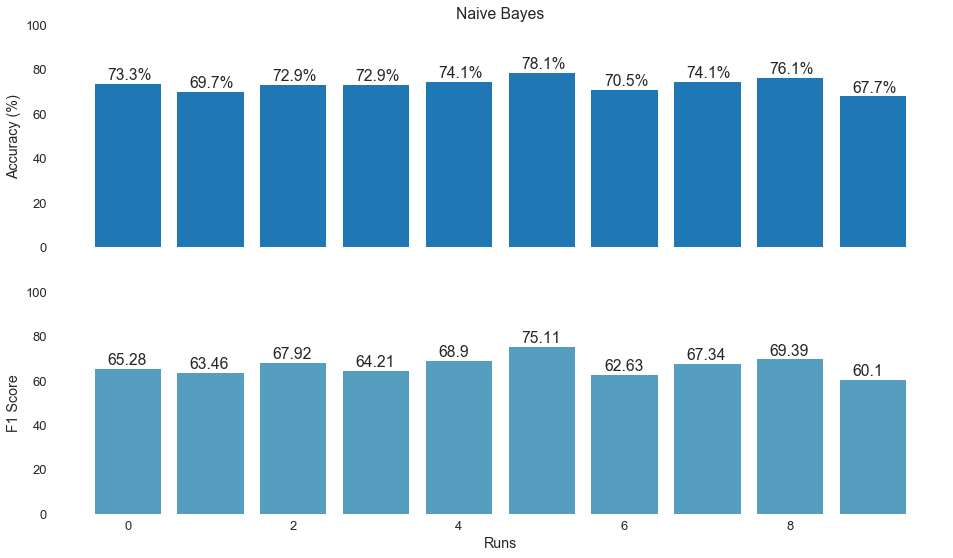

In [263]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Naive Bayes')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()

The F1 score fluctuates greater than 15 points between some runs, which could be remedied with a larger dataset. Let's see how other algorithms do.

### Other Classification Algorithms in scikit-learn

As you can see Naive Bayes performed pretty well, so let’s experiment with other classifiers.

We'll use the same shuffle splitting as before, but now we'll run several types of models in each loop:

In [264]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

X = df.headline
y = df.label

cv = ShuffleSplit(n_splits=20, test_size=0.2)

models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    MLPClassifier()
]

sm = SMOTE()

# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}

for train_index, test_index in cv.split(X):
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    for model in models:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)    

We now have a bunch of accuracy scores, f1 scores, and confusion matrices stored for each model. Let's average these together to get average scores across models and folds:

In [265]:
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

MultinomialNB
------------------------------
        Avg. Accuracy: 74.70%
        Avg. F1 Score: 69.63
        Avg. Confusion Matrix: 
        
[[114.05  36.4 ]
 [ 27.1   73.45]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 75.32%
        Avg. F1 Score: 67.96
        Avg. Confusion Matrix: 
        
[[122.75  27.7 ]
 [ 34.25  66.3 ]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 74.80%
        Avg. F1 Score: 68.31
        Avg. Confusion Matrix: 
        
[[119.2   31.25]
 [ 32.    68.55]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 71.75%
        Avg. F1 Score: 65.31
        Avg. Confusion Matrix: 
        
[[112.6   37.85]
 [ 33.05  67.5 ]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 73.01%
        Avg. F1 Score: 66.61
        Avg. Confusion Matrix: 
        
[[115.55  34.9 ]
 [ 32.85  67.7 ]]
        
RandomForestClassifier
------------------------------
  

We've gotten some pretty decent results, but overall it looks like we need more data to be sure which one performs the best. 

Since we're only running metrics on a test set size of about 300 examples, a 0.5% difference in accuracy would mean only ~2 more examples are classified correctly versus the other model(s). If we had a test set of 10,000, a 0.5% difference in accuracy would equal 50 more correctly classified headlines, which is much more reassuring.  

The difference between Random Forest and Multinomial Naive Bayes is quite clear, but the difference between Multinomial and Bernoulli Naive Bayes isn't. To compare these two further, we need more data.

Let's see if ensembling can make a better difference.

## Esembling Classifiers

After we evaluated each classifier individually, let's see if ensembling helps improve our metrics.

We're going to use sklearn's `VotingClassifier` which defaults to a *majority rule* voting.

In [266]:
from sklearn.ensemble import VotingClassifier

X = df.headline
y = df.label

cv = ShuffleSplit(n_splits=10, test_size=0.2)

models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    MLPClassifier()
]

m_names = [m.__class__.__name__ for m in models]

models = list(zip(m_names, models))
vc = VotingClassifier(estimators=models)

sm = SMOTE()

# No need for dictionary now
accs = []
f1s = []
cms = []

for train_index, test_index in cv.split(X):
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    vc.fit(X_train_res, y_train_res)
    
    y_pred = vc.predict(X_test_vect)
    
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))

In [267]:
print("Voting Classifier")
print("-" * 30)
print("Avg. Accuracy: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("Avg. F1 Score: {:.2f}".format(sum(f1s) / len(f1s) * 100))
print("Confusion Matrix:\n", sum(cms) / len(cms))

Voting Classifier
------------------------------
Avg. Accuracy: 75.78%
Avg. F1 Score: 68.51
Confusion Matrix:
 [[123.7  28.7]
 [ 32.1  66.5]]


Although our majority classifier performed great, it didn't differ much from the results we got from Multinomial Naive Bayes, which might have been suprising. Surely mashing a bunch together would give better results, but this lack of difference in performance proves that there's still a lot of areas that need to be explored. For example:
+ How more data affects performance (best place to start due to our small dataset)
+ Grid searching different parameters for each model
+ Debugging the ensemble by looking at model correlations
+ Trying different styles of [bagging, boosting, and stacking](https://stats.stackexchange.com/a/19053)

## Final words and where to go from here

So far we've 
+ Mined data from Reddit's /r/politics
+ Obtained sentiment scores for headlines
+ Vectorized the data
+ Run the data through several types of models
+ Ensembled models together

Unfortunately, there isn't an obvious winning model. There's a couple we've seen that definitely perform poorly, but there's a few that hover around the same accuracy. Additionally, the confusion matrices are showing roughly half of the positive headlines are being misclassified, so there's a lot more work to be done.

Now that you've seen how this pipeline works, there's a lot of room for improvement on the architecture of the code and modeling. I encourage you to try all of this out in the provided notebook. See what other subreddits you can tap into for sentiment, like stocks, companies, products, etc.. There's a lot of valuable data to be had!

### Help us make this article and series better

If you're interested in the expansion of this article and series into some of these areas of exploration, drop a comment below and we'll add it to the content pipeline. 

Thanks for reading!